In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F


%matplotlib inline

In [ ]:
# read all the words
words = open("./makemore/names.txt", "r").read().splitlines()
words[:10]

In [ ]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}

In [ ]:
# build the dataset

block_size = 3 # context length: how many charachters do we take to predict the next one?
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w +".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
import random
# build the dataset
def build_dataset(words):
    block_size = 3 # context length: how many charachters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w +".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join(itos[i] for i in context), "--->", itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [ ]:
# the dataset then looks as follows:
X.shape, X.dtype, Y.shape, Y.dtype

In [ ]:
C = torch.randn((27, 2))

In [ ]:
C[5]

In [ ]:
# Analogously to C[5], we can use the one_hot encoding:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

In [ ]:
# NOTE: indexing tensors works with lists/tensors aswell!
C[[1, 5, 7, 7 ,7]], C[torch.tensor([1, 5, 7, 7, 7])]

In [ ]:
emb = C[X]
emb.shape

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [ ]:
# emb @ W1 + b1 # this does not work, as you can see below!
emb.view(-1, 6) @ W1 + b1 # The "-1" as first argument makes torch find the correct number (32) on its own.

In [ ]:
torch.cat([emb[:, i, :] for i in range(3)], 1).shape

In [ ]:
torch.cat(torch.unbind(emb, 1), 1).shape # torch.unbind is equivalent to [emb[:, i, :] for i in range(3)]!

The following is equivalent again, but MUCH more efficient. Since `torch.cat()` creates a new tensor in memory.

In [ ]:
emb.shape

In [ ]:
a = torch.arange(15)
a.storage()

In [ ]:
# we simply view the [32, 3, 2] tensor as a [32, 6] tensor, which does not manipulate the memory storage
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1) # shows that both sides do the same

In [ ]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h, h.shape

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(1, keepdim=True)

In [ ]:
prob.shape, prob[0].sum() # we now have probabilities in each row of prob!

In [ ]:
loss = - prob[torch.arange(32), Y].log().mean()
loss 

In [ ]:
# ---- now more readable ----

In [ ]:
Xtr.shape, Ytr.shape # dataset

In [240]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [241]:
sum(p.nelement() for p in parameters) # number of trainable parameters in total

11897

In [ ]:
emb = C[X] # shape: [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()                                       # 1.
prob = counts / counts.sum(1, keepdim=True)                 # 2.
loss = - prob[torch.arange(emb.shape[0]), Y].log().mean()   # 3.
loss

In [ ]:
F.cross_entropy(logits, Y) # this is exactly the same as the above three lines but MUCH more efficient (no additional memory is used)

In [242]:
for p in parameters:
    p.requires_grad = True

In [ ]:
for _ in range(10):

    # forward pass
    emb = C[X] # shape: [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad



In [ ]:
# now we want to introduce batching

torch.randint(0, X.shape[0], (32,)) # randomly generates 32 indexes for samples in X

In [ ]:
# find optimal learning rate:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

In [220]:
lri = []
lossi = []
stepi = []

In [243]:
for i in range(500000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (64,)) 
    
    # forward pass
    emb = C[Xtr[ix]] # shape: [32, 3, 2]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()

    # update
    for p in parameters:
        # lr = lrs[i]
        lr = 0.1 if i < 100000 else 0.01
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(stepi[-1] + i)
    lossi.append(loss.log10().item())

In [190]:
loss.item()

2.1983706951141357

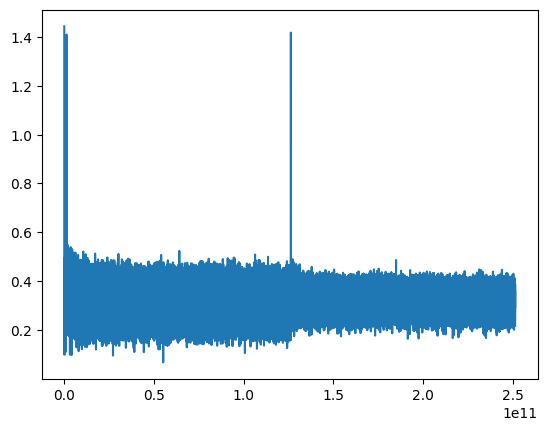

In [244]:
# plt.plot(lri, lossi)
plt.plot(stepi, lossi)

In [246]:
# loss for entire dataset
emb = C[Xtr] # shape: [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.094409465789795


In [245]:
# loss for entire dataset
emb = C[Xdev] # shape: [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.140080213546753


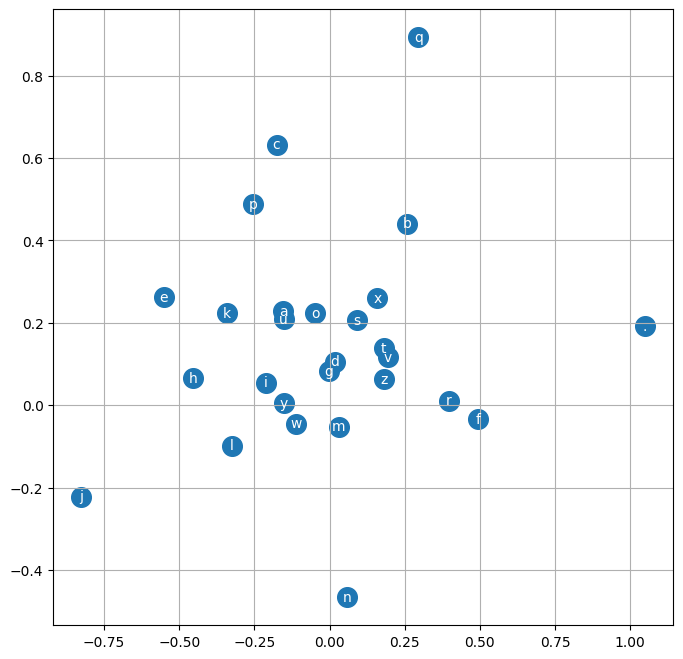

In [247]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color = "white")
plt.grid("minor")

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

Now we want to sample from the model

In [249]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with "..."
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if not ix:
            break

    print("".join(itos[i] for i in out))

carmah.
amille.
khi.
milia.
atlanna.
sakena.
hube.
delynn.
jareei.
nellara.
chaiir.
kaleigh.
ham.
pori.
quinn.
sulisea.
jadiq.
wanthoniearynix.
kael.
druli.
